# Clustering Impact on Query Times

Testing 3 different queries with varying levels of clustering.

Fairly small recordset, containing roughly two weeks worth of traffic data.

143M rows.

----


First is the `total_count` query, returning 1 row.
```
SELECT count(*) FROM 'sp-traffic'
```



Second is the `count_by_advertiser` query, returning 480 rows
```
SELECT advertiser_id, count(*) as cnt FROM 'sp-traffic' GROUP BY advertiser_id ORDER BY cnt DESC
```



Third is the `certain_advertiser_specific_dates` query, returning 11,041,908 rows
```
SELECT campaign_id, ad_group_id, ad_id, sum(clicks), sum(impressions), sum(cost), to_date(time_window_start) as date
FROM 'sp-traffic' 
WHERE advertiser_id = 'XXX'
GROUP BY date, campaign_id, ad_group_id, ad_id, keyword_id
```

In [20]:
import polars as pl

df = pl.read_csv("../times.csv")

In [24]:
# Group by query type and calculate min/max times
query_stats = df.group_by("query").agg(
    pl.col("time_ms").min().alias("min_time_ms"),
    pl.col("time_ms").max().alias("max_time_ms")
)

# Calculate differences
query_stats = query_stats.with_columns(
    (pl.col("max_time_ms") - pl.col("min_time_ms")).alias("abs_diff_ms"),
    ((pl.col("max_time_ms") / pl.col("min_time_ms"))).alias("speedup"),
)

# Round numeric columns to 2 decimal places for better display
query_stats = query_stats.with_columns(
    pl.col("speedup").round(2)
)

# Convert to pandas for nicer display in Jupyter
display(query_stats.to_pandas())

,query,min_time_ms,max_time_ms,abs_diff_ms,speedup
0,total_count,393,781,388,1.99
1,count_by_advertiser,656,1058,402,1.61
2,certain_advertiser_specific_dates,1307,5406,4099,4.14


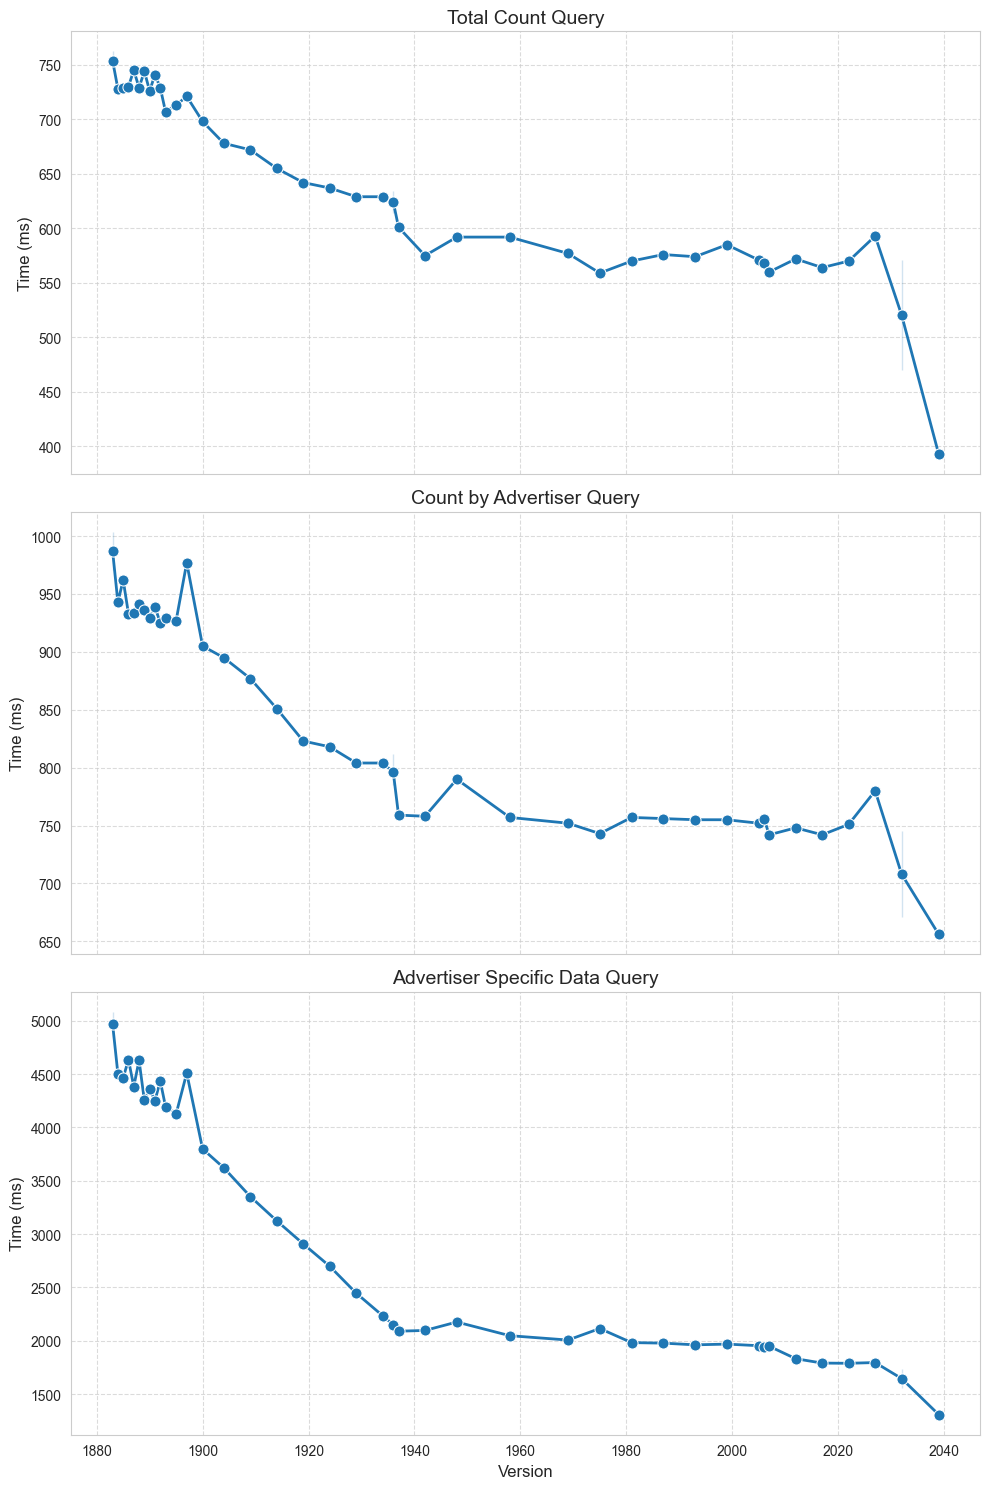

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking graphs
sns.set_style("whitegrid")

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Filter data for each query type and plot
query_types = ["total_count", "count_by_advertiser", "certain_advertiser_specific_dates"]
titles = ["Total Count Query", "Count by Advertiser Query", "Advertiser Specific Data Query"]

for i, (query_type, title) in enumerate(zip(query_types, titles)):
    # Filter data for this query type
    query_df = df.filter(pl.col("query") == query_type)
    
    # Sort by version to ensure correct ordering
    query_df = query_df.sort("version")
    
    # Plot on the appropriate subplot
    sns.lineplot(
        x="version", 
        y="time_ms", 
        data=query_df.to_pandas(), 
        marker='o',
        markersize=8,
        linewidth=2,
        ax=axes[i]
    )
    
    # Add title and labels
    axes[i].set_title(title, fontsize=14)
    axes[i].set_ylabel("Time (ms)", fontsize=12)
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)

# Set common x-axis label
plt.xlabel("Version", fontsize=12)

# Adjust layout and spacing
plt.tight_layout()
plt.show()